### Import Packages

In [1]:
#@title Imports

!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install transformers --quiet
!pip install pydot --quiet
!pip install tensorflow_addons --quiet

     |████████████████████████████████| 24.2 MB 6.1 MB/s 
     |████████████████████████████████| 4.9 MB 7.5 MB/s 
     |████████████████████████████████| 4.4 MB 7.1 MB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
     |████████████████████████████████| 101 kB 11.9 MB/s 
     |████████████████████████████████| 6.6 MB 6.1 MB/s 
     |████████████████████████████████| 1.1 MB 8.2 MB/s 


In [2]:
# Import packages
import pandas as pd
import numpy as np
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import tensorflow_addons as tfa

from google.colab import drive

from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams

from transformers import BertTokenizer, TFBertModel
from tqdm.notebook import tqdm
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
import tensorflow as tf


import time
from transformers import create_optimizer

import sklearn as sk
import os
import nltk
from nltk.corpus import reuters
from nltk.data import find

import re

import gensim
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel


In [3]:
pd.set_option("display.max_rows", None, # display all rows
              "display.max_columns", None, # display all columns
              "display.max_colwidth", None, # expand column width
              "display.html.use_mathjax", False) # disable Latex style mathjax rendering

In [4]:
drive.mount('/drive') 
%cd /drive/MyDrive/W266 Project/Colab Notebooks/Exploration
!pwd

Mounted at /drive
/drive/.shortcut-targets-by-id/1p1bDkEjmNKPzX456WZWBr8qtvPr6Pt5m/W266 Project/Colab Notebooks/Exploration
/drive/.shortcut-targets-by-id/1p1bDkEjmNKPzX456WZWBr8qtvPr6Pt5m/W266 Project/Colab Notebooks/Exploration


# Model - BERT

In [5]:
final_train = pd.read_csv('../../data/transformed/final/train.csv').sample(frac = 1) # shuffle rows
final_test = pd.read_csv('../../data/transformed/final/test.csv').sample(frac = 1) # shuffle rows

In [6]:

# 
# print(small_data_size, train_size, test_size, pos_exs, neg_exs)

In [7]:
small_data_size = 100000
train_split = .8
train_size = int(small_data_size * train_split)
test_size = small_data_size - train_size

# Reduce size of data for quick testing 
small_train = final_train.sample(n = train_size, 
                                 random_state = 2)
small_test = final_test.sample(n = test_size, 
                               random_state = 2)

# undersample_rate = .7
# pos_exs = int(train_size * .7)
# neg_exs = train_size - pos_exs

# # Simulate Undersampling
# small_train_1 = final_train[final_train['violent'] == 1]\
#                 .sample(n = pos_exs, 
#                         random_state = 2)
                
# small_train_0 = final_train[final_train['violent'] == 0]\
#                 .sample(n = neg_exs, 
#                         random_state = 2)
                
# small_train = pd.concat([small_train_1, small_train_0], 
#                         ignore_index=True, axis=0)

# repoint to avoid having to update code below
final_train = small_train
final_test = small_test

In [8]:
# quick check to make sure we see expected representation of 0 and 1
# final_train['violent'].value_counts()
final_test['violent'].value_counts()

0    18048
1     1952
Name: violent, dtype: int64

Import helper functions

In [9]:
#@title Plotting Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs, history1, 
              history2, 
              y_lim_loss_lower=0.4, 
              y_lim_loss_upper=0.6,
              y_lim_accuracy_lower=0.7, 
              y_lim_accuracy_upper=0.8,
              model_1_name='model 1',
              model_2_name='model 2',
              
             ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0, 0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - ' + model_1_name)
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax3 = axs[1, 0]
    ax3.set_title('accuracy - ' + model_1_name)
    ax3.plot(history1.history['accuracy'])
    ax3.plot(history1.history['val_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)


    ax2 = axs[0, 1]
    ax2.set_title('loss - ' + model_2_name)
    ax2.plot(history2.history['loss'])
    ax2.plot(history2.history['val_loss'])
    ax2.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax4 = axs[1, 1]
    ax4.set_title('accuracy - ' + model_2_name)

    # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
    if 'classification_accuracy' in history2.history.keys():
      ax4.plot(history2.history['classification_accuracy'])
    else:
      ax4.plot(history2.history['accuracy'])
    
    if 'val_classification_accuracy' in history2.history.keys():
      ax4.plot(history2.history['val_classification_accuracy'])
    else:
      ax4.plot(history2.history['val_accuracy'])
    ax4.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)

In [10]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
max_length = 128

x_train = bert_tokenizer(list(final_train['comment_text_transf']),
                         max_length = max_length,
                         truncation = True,
                         padding = 'max_length',
                         return_tensors = 'tf')
y_train = list(final_train['violent'])

In [12]:
x_test = bert_tokenizer(list(final_test['comment_text_transf'].apply(str)),
                         max_length = max_length,
                         truncation = True,
                         padding = 'max_length',
                         return_tensors = 'tf')
y_test = list(final_test['violent'])

In [29]:
def create_bert_cls_model(hidden_size = 100, dropout = .3, learning_rate = .00005, weight_decay = 0):
    bert_model = TFBertModel.from_pretrained('bert-base-cased', num_labels = 2)

    # Build the input layers
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    # Dictionary of inputs
    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask} 

    # bert_inputs = {'input_ids': input_ids} 

    # model output
    bert_out = bert_model(bert_inputs) 

    # Instead of pooled token, using the 'cls' token 
    pooled_token = bert_out[1]
    # cls_token = bert_out[0][:,0] # First layer, 0th column of each token set


    # Hidden layers
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_1')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_2')(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_3')(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_4')(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_5')(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_6')(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_7')(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_8')(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_9')(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_10')(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_11')(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_12')(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden) # was cls_token

    # instantiate model
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    # classification_model = tf.keras.Model(inputs=input_ids, outputs=[classification])
    
    # compile model
    classification_model.compile(optimizer=tfa.optimizers.AdamW(learning_rate = learning_rate,
                                                                weight_decay = weight_decay),
    # classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics=['Precision', 'Recall',
                                     'TrueNegatives', 'TruePositives', 
                                     'FalsePositives', 'FalseNegatives',
                                     'accuracy', 'AUC', 
                                     ])
   
    ### END YOUR CODE
    
    return classification_model

In [14]:
# bert_out = bert_model(bert_inputs, output_hidden_states = True) 

### Run a few iterations of the model with different configs

In [15]:
# bert_cls_model = create_bert_cls_model()

# bert_cls_model.summary()

# display(keras.utils.plot_model(bert_cls_model, show_shapes=True, dpi=90))

# bert_cls_model_history = bert_cls_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
#                                 np.array(y_train),   
#                                 validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], 
#                                                  np.array(y_test)),    
#                                 batch_size=8, 
#                                 epochs=2)


In [16]:
# bert_cls_model = create_bert_cls_model()

# bert_cls_model.summary()

# display(keras.utils.plot_model(bert_cls_model, show_shapes=True, dpi=90))

# bert_cls_model_history1 = bert_cls_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
#                                 np.array(y_train),   
#                                 validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], 
#                                                  np.array(y_test)),    
#                                 batch_size=8, 
#                                 epochs=2)


In [17]:
# 80/20 w 10k examples - no undersampling
# bert_cls_model = create_bert_cls_model()

# bert_cls_model.summary()

# display(keras.utils.plot_model(bert_cls_model, show_shapes=True, dpi=90))

# bert_cls_model_history1 = bert_cls_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
#                                 np.array(y_train),   
#                                 validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], 
#                                                  np.array(y_test)),    
#                                 batch_size=32, 
#                                 epochs=10)

In [18]:
# # 80/20 w 10k examples - undersampling simulated @ 50%

# bert_cls_model = create_bert_cls_model()

# bert_cls_model.summary()

# display(keras.utils.plot_model(bert_cls_model, show_shapes=True, dpi=90))

# bert_cls_model_history1 = bert_cls_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
#                                 np.array(y_train),   
#                                 validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], 
#                                                  np.array(y_test)),    
#                                 batch_size=8, 
#                                 epochs=2)

In [19]:
# 80/20 w 10k examples - undersampling simulated @ 50%

# bert_cls_model = create_bert_cls_model()

# bert_cls_model.summary()

# display(keras.utils.plot_model(bert_cls_model, show_shapes=True, dpi=90))

# bert_cls_model_history2 = bert_cls_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
#                                 np.array(y_train),   
#                                 validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], 
#                                                  np.array(y_test)),    
#                                 batch_size=32, 
#                                 epochs=5)

In [20]:
# bert_cls_model.predict()

### Test chunk

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

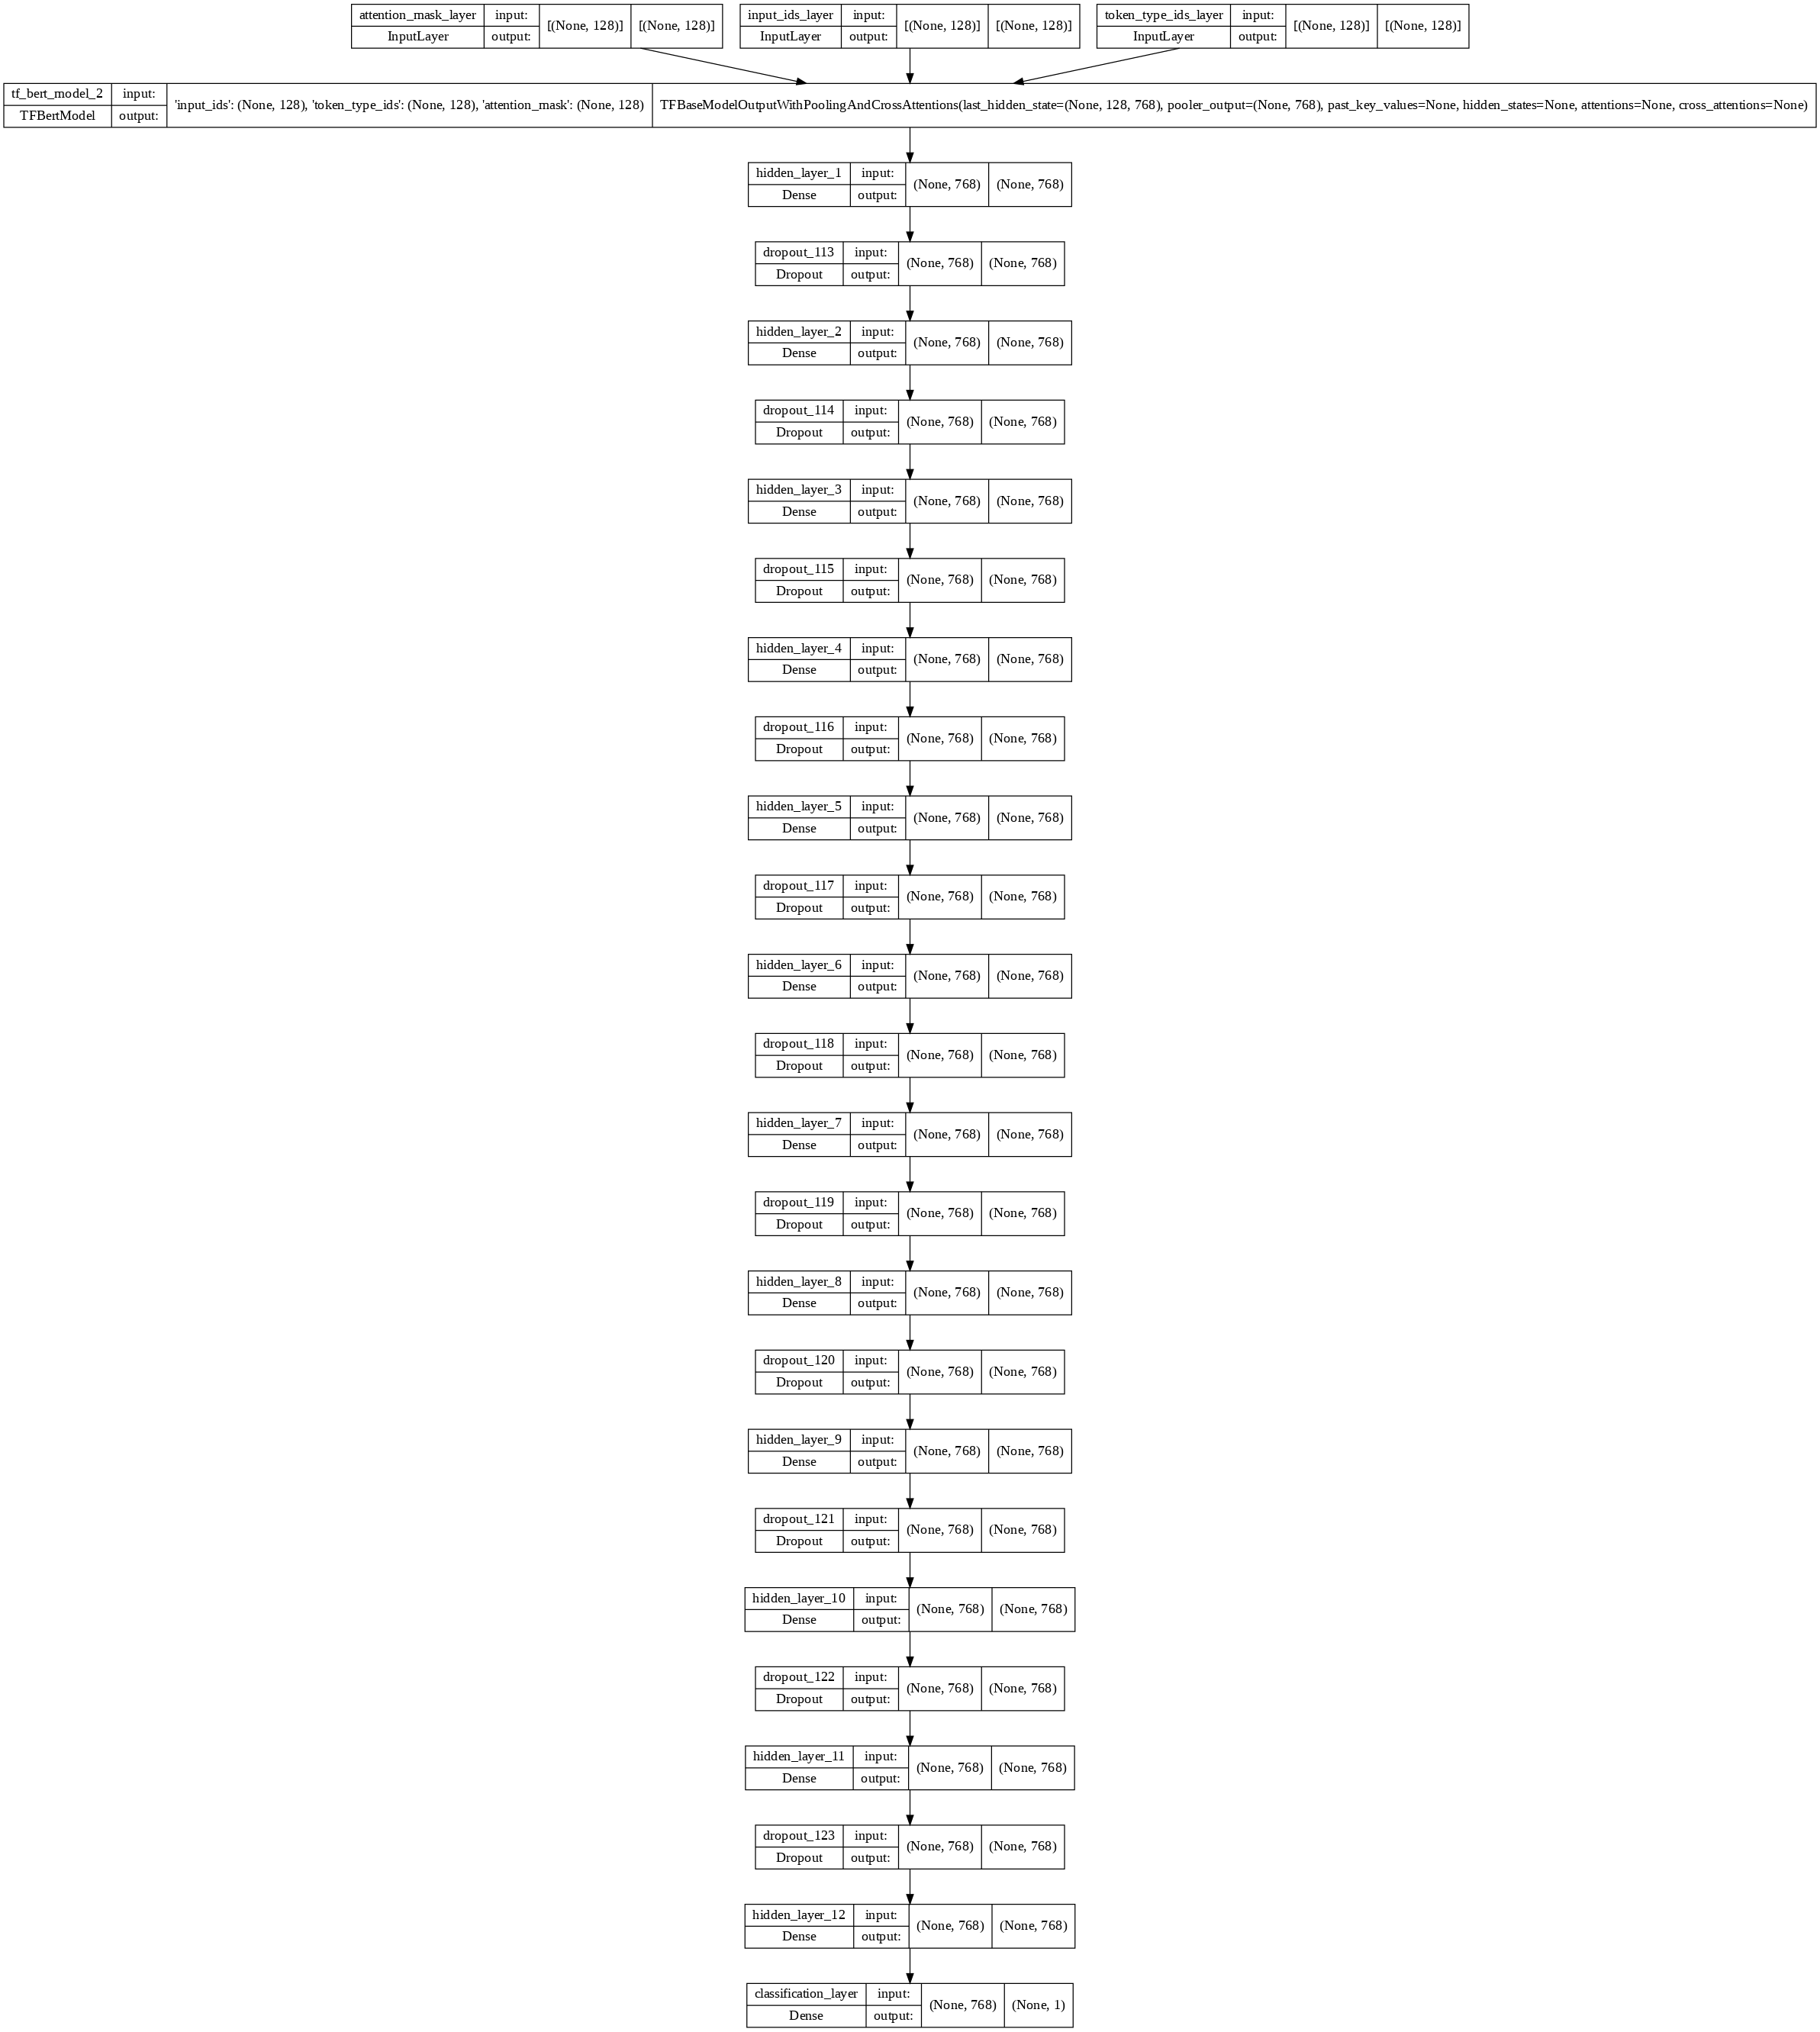

Epoch 1/5
2500/2500 [==============================] - 1316s 522ms/step - loss: 0.1336 - precision: 0.8497 - recall: 0.5890 - true_negatives: 70957.0000 - true_positives: 4824.0000 - false_positives: 853.0000 - false_negatives: 3366.0000 - accuracy: 0.9473 - auc: 0.9640 - val_loss: 0.3403 - val_precision: 0.5173 - val_recall: 0.8873 - val_true_negatives: 16432.0000 - val_true_positives: 1732.0000 - val_false_positives: 1616.0000 - val_false_negatives: 220.0000 - val_accuracy: 0.9082 - val_auc: 0.9624
Epoch 2/5
2500/2500 [==============================] - 1301s 520ms/step - loss: 0.0734 - precision: 0.8889 - recall: 0.8264 - true_negatives: 70964.0000 - true_positives: 6768.0000 - false_positives: 846.0000 - false_negatives: 1422.0000 - accuracy: 0.9717 - auc: 0.9880 - val_loss: 0.2409 - val_precision: 0.5168 - val_recall: 0.8914 - val_true_negatives: 16421.0000 - val_true_positives: 1740.0000 - val_false_positives: 1627.0000 - val_false_negatives: 212.0000 - val_accuracy: 0.9081 - val_

In [30]:
# 80/20 w 10k examples - undersampling simulated @ 70%

bert_cls_model = create_bert_cls_model(hidden_size = 768, dropout = .2, learning_rate = .00002)

bert_cls_model.summary()

display(keras.utils.plot_model(bert_cls_model, show_shapes=True, dpi=90))

bert_cls_model_history2 = bert_cls_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                np.array(y_train),   
                                validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], 
                                                 np.array(y_test)),    
                                batch_size=32, 
                                epochs=5)

In [28]:
2+eeii

4

4

In [ ]:
# score = bert_cls_model.evaluate([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], 
#                                                  np.array(y_test))

In [ ]:
# final_test['comment_text_transf']

In [22]:
# bert_cls_model.predict([x_test.input_ids[:10], x_test.token_type_ids[:10], x_test.attention_mask[:10]])
predictions_out = bert_cls_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])

In [23]:
predictions = predictions_out

predictions_prob = pd.Series(predictions.flatten())
predictions = pd.Series(np.rint(predictions).flatten(), dtype = int)
test_ids = pd.Series(final_test.index)
test_check = final_test
test_check = test_check.reset_index(drop = True)
test_check = pd.concat([test_check, predictions, predictions_prob, test_ids], axis = 1)
test_check.rename(columns = {'violent': 'actual', 0: 'prediction', 2: 'id', 1: 'prediction_prob'}, inplace = True)
test_check.set_index('id', inplace = True)
test_check = test_check[['comment_text_transf', 'actual', 'prediction', 'prediction_prob']]

In [24]:
wrong_predictions = test_check[test_check['actual'] != test_check['prediction']]

In [ ]:
!ls ../../data/model_output

In [25]:
wrong_predictions.to_csv('../../data/model_output/wrong_predictions_26.csv')

In [ ]:
fp = wrong_predictions[wrong_predictions['prediction'] == 1]
fn = wrong_predictions[wrong_predictions['prediction'] == 0]

In [ ]:
fp.sample(10)

,comment_text_transf,actual,prediction,prediction_prob
id,,,,
12823,"I'm very much an agnostic. I didn't oppose beucase of that comment, which isn't that bad at all. I opposed becuase someone later came to his talk page saying he felt insulted by the comment, and Teratornis basically told him to fuck off. At least that's the message I get after reading Teratornis's comments./",0,1,0.718399
38677,"What tge hell! You should be ashamed what you have done. And, when are you going to consult an administrator for cgeckuser? People are not commenting on my flc for that reason. This shows your hypocrisy and hate towards Chopra as you don't want that her flc to be afeatured one and later faetured topic. Please, ask the administrator do handle it ASAP as my exams are going to start in two days.—",0,1,0.963165
8346,"Francisco Pizarro was not a conqueror, he was an invader, a thief, torturer, assassin, racist genocidal.",0,1,0.796034
53680,Not Nazi Wiki Nazi http//wikiality.wikia.com/Wikinazi.,0,1,0.985292
29894,I am sick and tired of the lack of discussion here. Somebody start some discussion.,0,1,0.600118
14389,abcd . you come with me efg.he killed me!!!,0,1,0.626098
28460,retards,0,1,0.992805
38398,"Sockpuppets This guy and this guy UserKnight Crawler X are obvious sockpuppets. They edit the same page over and over again, and his reason for not being a sockpuppet is very obvious, thinking that having different e mails will not determine being a sockpuppet. You act as if you're an administrator and when we call for help, you ignore it? Grow some balls.",0,1,0.540524
32328,You two britmax. Go behind the line.,0,1,0.531410


In [ ]:
fp.sample(15, random_state = 2)

,comment_text_transf,actual,prediction,prediction_prob
id,,,,
33054,Odious cunt Should be your new name.,0,1,0.991505
25211,"Busta Rhymes Beef?! This is complete rubbish, has nothing to back it up and no records of it on any of the major hip hop sites from the time it claims to be from, should be deleted ASAP.",0,1,0.862702
51783,She's not a freakin lesbian,0,1,0.634996
24519,"Oh wait, I forgot! Fred Phelps of Westboro Baptist Church supports the perpetrator. How could I be so stupid! His views MUST be represented in the article at all costs NOT!",0,1,0.853300
48092,"And then you doctored your post to try to make it appear you had tried to do so. Wholesale text reversions without bothering to explain, nasty temper tantrums, bitchiness, personal attacks, disingenuous reediting of the talk page for your benefit. Tsk, tsk, tsk. All that is bad enough for the lowly lumpen, but for an admin? Shame on you! wagging finger ;p",0,1,0.904914
36126,"Hey It's been a long while, and sometimes I wonder if anything changes at all. When thinking about this, what the fuck kind of genre is NWOAHM? I've NEVER heard a band that wasn't something else. And as an aside, I'm sick of the fucking Lucifugum page being deleted. I think I'll try to recreate it, but the lovely people here probably salted it after last time. See you around? P.S. Thanks for getting me kickstarted here; although when looking over the diffs you warned me about for old time's sake, you misread as OR you misread the red text as what I had written, but I had just merged two paragraphs together, so the second one showed up red, so I feel a bit vindicated ;",0,1,0.981864
21066,"OH, IC, He trolls me and you abuse the project for being firm with the maniac. He needs a shrink, and I said so. That's truly effective liberal thinking just like the multi trillion dollar pillage and rapine congress just began //",0,1,0.680600
63573,Have you ever seen a picture of the guy? Holy Jesus that man is ugly!,0,1,0.943767
49152,"Corrupt, not in the financial sense, but in a if they're one of our mates, then we're gonna look after them kinda way. I think if I knew someone who was joining WP now, my advice to them would be to pretend you're female, or at least come across that you are. That way you'll have the GGTF and every other liberal do gooder falling at your feet and watching your back. All of the females I know on here couldn't give a shit for how gender divided apparently it is on here; they are here to write, and bloody good they are too.",0,1,0.766772


In [ ]:
fn.sample(15, random_state = 2)

,comment_text_transf,actual,prediction,prediction_prob
id,,,,
3232,I HAVE A HUGE PENIS,1,0,0.394173
3774,"PENIS, PENIS, PENIS, VAGINA, VAGINA, VAGINA'Bold text'",1,0,0.010238
2466,What is this doing here? used in oral encounters with the opposite or same sex.Usually in the anal area to enhance the anal butt hole pleasures. Is this for real?,1,0,0.023464
4047,"agree claiming a paulites has a different view on foreign policy than ron paul is moronic, or deliberate.",1,0,0.056590
2650,WTF U,1,0,0.158484
5123,screw u fuds!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! u need 2 get a life u computer nerds!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Down with celtic down with hearts,1,0,0.493824
3514,"Once she is too old to be called a heifer, she is just a cow.",1,0,0.104940
4090,LOLOL SAND NIGGA BEST BE TROLLIN LOLOLOLOL,1,0,0.473670
4462,"Penis size in Demographics section Does anyone else think it is a little ridiculous that basically 1/4th of the demographics section is about penis size? Look at the country pages for Canada, Japan, France. None of them ever mention this at all, much less belabor the idea. I think we should remove or change it, because it's unencyclopedic as is. The emphasis as is represents some kind of weird fetishistic POV and is not NPOV.",1,0,0.434103


In [ ]:
#'run before' this cell

In [ ]:
ex_1 = fp['comment_text_transf'][18207]
ex_2 = "' == for those of you who didn't realize i'm retired and here's my retirement speech == i haven't edited in months (which is like lifetimes away from wikipedia) and i don't really want to edit. sometimes i edit once in a long while on anon ip's but just little things like spelling and grammar. i'm sick of all the arguing that takes place on wikipedia. i'm tired of people not following the rules and tired of people who instead of having a conversation, jump the bit and be disrespectful and start wars. i'm tired of articles like nwoahm (i can't believe it still exists) which is an article about something that doesn't exist but because the guy promoting it has a few sources, due to some people who mentioned the subject in their professional music articles, it's okay and the article is not outright deleted for being misinformation as it should be. i'm tired of the addiction that wikipedia brought on. i'm tired of the time it sucked up. i'm tired of talking…'"

In [ ]:
2+2

4

In [ ]:
text_examples = [ex_1, ex_2]

AttributeError: ignored

In [ ]:
text_examples

[" == for those of you who didn't realize i'm retired and here's my retirement speech == i haven't edited in months (which is like lifetimes away from wikipedia) and i don't really want to edit. sometimes i edit once in a long while on anon ip's but just little crap like spelling and grammar. i'm sick of all the fighting, stupidity and unfairness that takes place on wikipedia. i'm tired of people not following the rules and tired of people who instead of having a conversation, jump the gun and be total dumbfucks and start wars. i'm tired of articles like nwoahm (i can't believe it still exists) which is an article about something that doesn't exist but because the guy promoting it has a few sources, due to some retarded shits who mentioned the subject in their professional music articles, it's okay and the article is not outright deleted for being misinformation as it should be. i'm tired of the addiction that wikipedia brought on. i'm tired of the time it sucked up. i'm tired of talki

In [ ]:
# bert_tokenizer(a,
#                          max_length = 128,
#                          truncation = True,
#                          padding = 'max_length',
#                          return_tensors = 'tf')

### Improvement Ideas:
1. check word/weight pairs using model.predict (see code chunk 44 in GL A2 - submitted)
2. Include better transforms
3. find commonly confused sentences
  
  a. check cosine similarity between occurrances that are commonly confused
4. Use Bertweet model? https://huggingface.co/docs/transformers/model_doc/bertweet
5. Play with BertConfig parameters
  
  a. num_attention_heads, num_hidden_layers, hidden_dropout_prob, attention_probs_dropout_prob, 

6. Check if some common words found in violent texts are not tokenized, or commonly end up as [UNK]
7. Try other bert architecture/configs (i.e. pooler, cls, BERT averaging, CNN on top)



### Tokenization Study
After running a few models and noting some trends related to Epochs, batch size, and sampling methods - let's look a bit at some of the tokenization to see if this might be adding to our model's confusion. 

Using the same tokenizer as above, looking at a few vector representations

First, we can take a look at the embeddings just based on the pre-trained tokenizer. Once we have those, we can compare across a few different tokenization strategies and see how that might affect our ability to classify. 

#### Pre-trained model
Because our fine-tuned model is currently running with max token length of 128, we need to retain that in this model, even though the test sentences i've included below are much smaller. 

Note: The following process provided numerous roadblocks when done in tensorflow. Referencing [documentation in Pytorch](https://https://www.analyticsvidhya.com/blog/2021/05/measuring-text-similarity-using-bert/) helped remove some roadblocks, so for the purpose of examining similarity in vectors, we will temporarily move to a pytorch implementation. 

This won't give us any difference in true output, it is just a different syntax in terms of creating vectors. 

In [ ]:
def compute_similarity(raw_sentences, max_length = 128):
    
    sent = raw_sentences
    
    #Initialize model and tokenizer:
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    model = BertModel.from_pretrained('bert-base-cased')

    # Tokenize the sentences
    # initialize dictionary: stores tokenized sentences
    token = {'input_ids': [], 'attention_mask': []}
    for sentence in sent:
        # encode each sentence, append to dictionary
        new_token = tokenizer.encode_plus(sentence, max_length=max_length,
                                          truncation=True, padding='max_length',
                                          return_tensors='pt')
        token['input_ids'].append(new_token['input_ids'][0])
        token['attention_mask'].append(new_token['attention_mask'][0])
    # reformat list of tensors to single tensor
    token['input_ids'] = torch.stack(token['input_ids'])
    token['attention_mask'] = torch.stack(token['attention_mask'])

    #Process tokens through model:
    output = model(**token)
    output.keys()

    #The dense vector representations of text are contained within the outputs 'last_hidden_state' tensor
    embeddings = output.last_hidden_state
    # embeddings

    att_mask = token['attention_mask']
    att_mask.shape

    mask = att_mask.unsqueeze(-1).expand(embeddings.size()).float()
    mask.shape

    mask_embeddings = embeddings * mask
    mask_embeddings.shape

    #Then we sum the remained of the embeddings along axis 1:
    summed = torch.sum(mask_embeddings, 1)
    summed.shape

    #Then sum the number of values that must be given attention in each position of the tensor:
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    summed_mask.shape

    mean_pooled = summed / summed_mask
    mean_pooled

    # convert from PyTorch tensor to numpy array
    mean_pooled = mean_pooled.detach().numpy()
    # calculate
    return cosine_similarity(
        mean_pooled)


Now that each of our example sentences are tokenized and mapped to the input ID from BERT, we can start to pull apart the embeddings and masking in order to measure similarity. 

There are two paths we can follow to understand how embeddings are impacting our classification task: 

1. Before training, how distant are embedding representations of text that we think should be considered different? 

2. Based on training results, can we increase the distance in text based on different pre-processing techniques? 

#### First, let's look at how similar embeddings are for sentences that a human would detect obvious difference in sentiment. 

We will use the following sentences as our test cases. These are user-generated, not a part of our train or test data. 

1. this is a fairly benign sentence
2. this sentence has some shhhhiiiiittttt in it
3. I want to hurt you
4. can I give you a hug?
5. I'm going to find you and murder you

In [ ]:
test_text_1 = ['this is a fairly benign sentence', 
        'this sentence has some shhhhiiiiittttt in it', 
        'i want to hurt you',
        'can i give you a hug?',
        "i'm going to find you and murder you"]

We can run these sentences through our `compute_similarity` function to see how far they sit apart in the vector space, based on pre-trained bert word embeddings. 

we should expect the following, based on our human understanding of violence and toxicity. 
1. Sentence 1 and 4 should be similar, as they are both fairly common sentences that don't emote violent or toxic intent. 
2. 3 and 5 should be most similar, as they are direct violent threats
3. 2, 3, and 5 should have some similarity, as they all contain some level of toxicity at a minimum

A few observations that will make our classification task difficult based on these embedding examples:
- Sentence 1 seems to be fairly similar with 2 and 5, which is fairly toxic. This doesn't seem intuitive
- Sentence 3 is highly similar to 5 (both violent), but it also looks quite similar to sentence 4, which is highly non-violent. 
- From a violence perspective, sentence 4 and 5 should be exact opposites. Therefore, we'd expect them to have a negative cosine similarity score. Not only is their score positive, but it is quite high in similarity


Based on these few examples, we can say there is maybe some success in determining violence vs. non-violence in terms of *relative* similarity, but for the most part, it is apparent that 'similarity' is not probably based much on violence in BERT's pre-training. This makes our classification task more difficult, and motivates some intentional changes to transformation. 

#### Second, let's see if we can help our model out a bit by choosing tokenization strategies that push our embeddings in the relative direction we'd like. 

Throughout early iterations of modeling, we were applying a few transforms that we believed would improve the power of our model. However, after further EDA, we notice we remove some possible correlation between text and violent/non-violent intent. Two examples of this confusion: 
1. Transform all comments to lower-case

2. Replace certain punctuation like "!" with ".". 

These early models achieved fairly low precision. After digging into the data for additional patterns, it was discovered that on average 14% of violent comments contained fully capitalized tokens, whereas only 5% of non-violent comments were capitalized. 

Additionally, Violent comments contained 10 times as many exclamations points, on average, compared to non-violent comments. 

Surpressing these differences in language reduced the power of our model. We can also see that they should affect the embeddings as well. 

In [ ]:
test_text_2 = ["to kill a mockingbird is a pretty sad book that even deals with murder. ", 
               "I am going to FIND YOU and KILL YOU!", 
               "I am going to find you and kill you."]

We can compare a relatively normal sentence about the book 'To kill a mockingbird' to the same sentence, with two different tokenizations. 

As we expected, the example that retains it's capitalization and punctuation is less alike the baseline sentence compared to the 3rd sentence, which is expected from a violent speech standpoint. 

This is a key example that highlights the importance of different transformation strategies. 

In [ ]:
compute_similarity(test_text_2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


array([[0.9999999, 0.7670758, 0.8069062],
       [0.7670758, 1.0000001, 0.8496529],
       [0.8069062, 0.8496529, 1.       ]], dtype=float32)

We can see in extreme cases, though, that this lack of transforms can have negative effects. For example, the sentence about being excited about a birthday is very similar to being excited for someone to die, based on the upper-case and use of exclamation points. 

In [ ]:
test_text_3 = ["I AM SO EXCITED FOR THE BIRTHDAY PARTY!!!", 
               "YOU ARE AN AWFUL HUMAN! I AM EXCITED FOR YOU TO DIE!", 
               "I am going to murder you."]
compute_similarity(test_text_3)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


array([[0.99999976, 0.9585645 , 0.6576083 ],
       [0.9585645 , 1.        , 0.6557969 ],
       [0.6576083 , 0.6557969 , 1.0000001 ]], dtype=float32)

Because we know there is such a disparate difference in use of capitals and exclamation points as noted above, we still choose to not surpress these language differences. We expect in the majority of cases the difference will lead toward better classification, not worse. 

In addition to the ID representation, we can see how this pre-trained tokenizer has tokenized our input: 

In [ ]:
for text in text_examples:
  print('Original text:', text)
  print('Tokenized:    ', bert_tokenizer.tokenize(text))


Original text: this is a fairly benign sentence
Tokenized:     ['this', 'is', 'a', 'fairly', 'ben', '##ign', 'sentence']
Original text: this sentence has some shhhhiiiiittttt in it
Tokenized:     ['this', 'sentence', 'has', 'some', 's', '##hh', '##hh', '##ii', '##ii', '##itt', '##tt', '##t', 'in', 'it']
Original text: this fucking sentence is awful and sucks ass
Tokenized:     ['this', 'fucking', 'sentence', 'is', 'awful', 'and', 'sucks', 'ass']
Original text: i want to hurt you
Tokenized:     ['i', 'want', 'to', 'hurt', 'you']
Original text: i'm going to find you and murder you
Tokenized:     ['i', "'", 'm', 'going', 'to', 'find', 'you', 'and', 'murder', 'you']
Original text: please do not hurt me
Tokenized:     ['please', 'do', 'not', 'hurt', 'me']
